<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/William_branch/Colour_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!make -C sparse_gaussian_elimination a.so

make: Entering directory '/content/sparse_gaussian_elimination'
make: 'a.so' is up to date.
make: Leaving directory '/content/sparse_gaussian_elimination'


In [2]:
#@title Preamble
import os
import threading
import torch.multiprocessing as multiprocessing
import functools
import random
from math import log, sqrt, exp

import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from scipy.special import logsumexp, softmax, log_softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW, SGD

from kfp import construct_A, construct_B, diffusion_coeff, marginal_prob_std, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, solve_pde, jacobi
from network import ScoreNet

import PIL

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
# if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
#     os.system("make -C ../sparse_gaussian_elimination a.so")
cifar = CIFAR10('.', download=True)

Files already downloaded and verified


In [3]:
#@title Construct the grid and Initial values
batch_size = 1 #@param
N = 20
H = 28
W = 28
epoch = 2000 #@param
eps = 1e-6 #@param
lr = 1e-3 #@param

channels = 3
dt = 1/N
sigma = 25 #@param
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
#@title Download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 1, replace=False)]

218 0


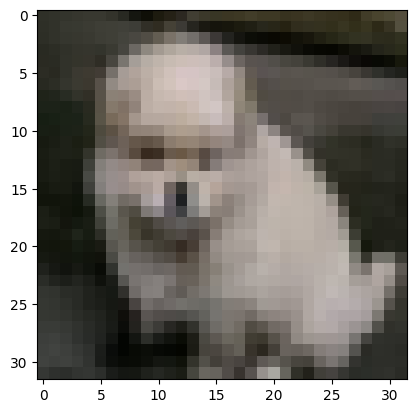

1.0 0.0


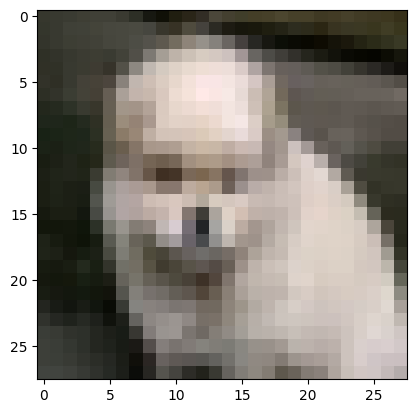

In [5]:
#@title Cropping the image
cropped_image_g = np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 28, 28)))
cifar_data_list_grey = [torch.Tensor(cropped_image_g)]

cifar_data_list = []
cifar_data_list_tensor = []
for i in range(batch_size):
  cropped_image_rgb = np.array(PIL.Image.fromarray(np.array(cifar_data[i])).convert("RGB").crop((0, 0, 28, 28)))
  cifar_data_list.append((cropped_image_rgb - cropped_image_rgb.min())/(cropped_image_rgb.max() - cropped_image_rgb.min())) # normalized to [0, 1]
  # cifar_data_list = [cropped_image_rgb]
  cifar_data_list_tensor.append(torch.Tensor(cifar_data_list[0].transpose((2, 0, 1))))

  print(cifar_data[i].max(), cifar_data[i].min())
  plt.imshow(cifar_data[i])
  plt.show()

  print(cifar_data_list[i].max(), cifar_data_list[i].min())
  plt.imshow((cifar_data_list[i] - cifar_data_list[i].min())/(cifar_data_list[i].max() - cifar_data_list[i].min()))
  plt.show()

In [6]:
#@title Defining pde diffusion per thread
def diffuse(initial_m, m, dm, channel, time_, g, scores):

  m[0, channel] = initial_m[channel]
  dh = 1

  A_block = []
  for i in range(1, N):
    f = np.zeros((H*W))
    df = np.zeros((H*W))
    A = construct_A(dh, dt, f, df, g(time_[i]), scores[i, channel], H, W)#
    if i == 1:
      A_block = sp.linalg.block_diag(A)
    else:
      A_block = sp.linalg.block_diag(A_block, A)
      A_block[(i-1)*(H*W):i*(H*W), (i-2)*(H*W):(i-1)*(H*W)] = -np.eye((H*W))

  B_block = []
  for i in range(1, N):
    B = construct_B(m[i-1, channel], i, H, W)
    B_block.append(B)
  B_block = np.concatenate(B_block)
  m[1:, channel] = solve_pde(A_block, B_block, mode='sparse').reshape((-1, H*W))

  img_log_prob = m[:, channel]
  dm[:, channel, 1:-1] = (img_log_prob[:, 2:] - img_log_prob[:, :-2])/(2*dh) # (img_log_prob[:, 1:-1, 2:] - img_log_prob[:, 1:-1, :-2])/(2*dy)
  dm[:, channel, 0] = (img_log_prob[:, 1] - 0)/(2*dh) #+ (img_log_prob[:, 1:-1, 0] - img_log_prob[:, 1:-1, -1])/dy
  dm[:, channel, -1] = (0 - img_log_prob[:, -2])/(2*dh) #+ (img_log_prob[:, 1:-1, -1] - img_log_prob[:, 1:-1, 0])/dy
  # dm[:, channel, 0 , 1:-1] = (img_log_prob[:, 0, 2:] - img_log_prob[:, 0, :-2])/(2*dy) + (img_log_prob[:, 0, 1:-1] - img_log_prob[:, -1, 1:-1])/dx
  # dm[:, channel, -1 , 1:-1] = (img_log_prob[:, -1, 2:] - img_log_prob[:, -1, :-2])/(2*dy) + (img_log_prob[:, -1, 1:-1] - img_log_prob[:, 0, 1:-1])/dx

In [8]:
#@title Precompute score labels by solving the PDE
threads = [None] * channels

m = np.zeros((N, channels, H*W), dtype=np.float32)
m_prev = np.ones((N, channels, H*W), dtype=np.float32)
scores = np.zeros((N, channels, H*W), dtype=np.float32) # initial scores guess
dm = np.zeros_like(scores, dtype=np.float32)
tol = 1e-3 #@param
max_iter = 1000 #@param
res = 1
e = 0

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  y_train = []
  for j in range(H):
    y_train.append(data[:, j, :])
  y_train = np.concatenate(y_train, axis=-1)

  x_train = []
  for l in range(W):
    x_train.append(data[:, :, l])
  x_train = np.concatenate(x_train, axis=1)

  init_m = []
  for ch in range(channels):
    xy_train = np.vstack([x_train[ch], y_train[ch]])
    kde_kernel = stats.gaussian_kde(xy_train)
    init_m.append(kde_kernel.logpdf(xy_train)[None])
  init_m = np.concatenate(init_m)

while res > tol:
  res_prev = res
  for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
    # we want to sample from random time steps to construct training samples
    time_ = np.linspace(eps, 1., N)

    # diffuse all three channels concurrently
    for ch in range(channels):
      diffuse(init_m, m, dm, ch, time_, diffusion_coeff_fn, scores)

    scores = dm.copy()

    if e == max_iter:
      print(f'No convergence')
      break

    res = np.linalg.norm(m - m_prev)/np.linalg.norm(m_prev)
    print(f'residual at iteration {e}: {res}')

    m_prev = m.copy()
    e += 1

  if abs(res_prev - res) < 1e-6:
    break

scores_label = scores.copy().reshape((-1, channels, H, W))

1it [00:00,  4.21it/s]
1it [00:27, 27.59s/it]


residual at iteration 0: 0.7859163880348206


1it [00:27, 27.13s/it]


residual at iteration 1: 0.06454908847808838


1it [00:26, 26.01s/it]


residual at iteration 2: 0.021781332790851593


1it [00:25, 25.98s/it]


residual at iteration 3: 0.008912273682653904


1it [00:26, 26.19s/it]


residual at iteration 4: 0.0044075301848351955


1it [00:26, 26.68s/it]


residual at iteration 5: 0.0024140668101608753


1it [00:26, 26.19s/it]


residual at iteration 6: 0.0014549894258379936


1it [00:26, 26.12s/it]

residual at iteration 7: 0.0009586348314769566


1.0190872 -1.2218195


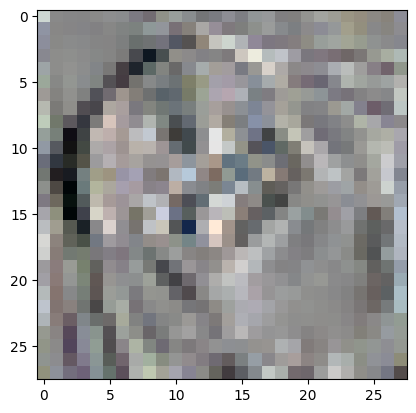

0.092561126 -0.05308502


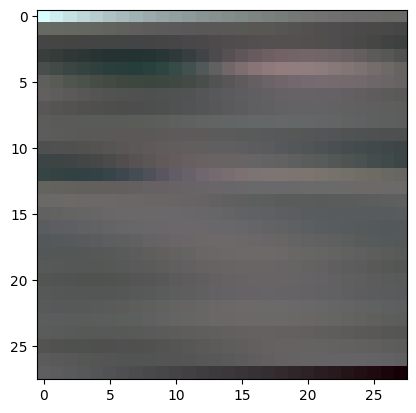

In [9]:
#@title Show the score labels
print(scores_label[0].max(), scores_label[0].min())
plt.imshow(((scores_label[0] - scores_label[0].min())/(scores_label[0].max() - scores_label[0].min())).transpose(1, 2, 0))
plt.show()
print(scores_label[-1].max(), scores_label[-1].min())
plt.imshow(((scores_label[-1] - scores_label[-1].min())/(scores_label[-1].max() - scores_label[-1].min())).transpose(1, 2, 0))
plt.show()

In [10]:
#@title Denoising network training
def loss_fn(model, x, label, diffusion_coeff, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.tensor(np.sort(np.random.uniform(eps, 1., N)).astype(np.float32))
  # we encode the label into the initial data using the reverse ODE
  diff_std2 = diffusion_coeff(2 * random_t)
  for i in range(1, N):
    x[i] = x[i-1] - 0.5 * label[i-1] * diff_std2[i-1] * dt
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x)
  # we perturb the image by the forward SDE conditional distribution
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  # loss = torch.mean((diff_std2) * torch.sum((score * std[:, None, None, None] - label)**2, dim=(1, 2, 3)) / (2 * diff_std2))
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3))) # original loss from tutorial
  return loss

In [11]:
#@title Function for training on a thread
def diffuse_train(init_x, epoch, diffusion_coeff, marginal_prob_std, label):
  model_score = ScoreNet(marginal_prob_std=marginal_prob_std)
  optimizer = Adam(model_score.parameters(), lr=lr)
  model_score.train();

  scores_label = torch.tensor(label)

  for e in range(epoch):
    loss = loss_fn(model_score, init_x, scores_label, diffusion_coeff, marginal_prob_std)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'\nloss: {loss}')
  file = f'model_cifar.pth'
  torch.save(model_score.state_dict(), file)
  print(f"model has been saved\n")

In [12]:
#@title Training the score-network
if os.path.exists(f'model_cifar.pth'):
  print(f'removing saved weights\n')
  os.remove(f'model_cifar.pth')

init_x = torch.zeros((N, channels, H, W))

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  for i in range(N):
    init_x[i] = data
  diffuse_train(init_x, epoch, diffusion_coeff_fn, marginal_prob_std_fn, scores_label)

removing saved weights



1it [03:08, 188.84s/it]


loss: 60.731040954589844
model has been saved



In [16]:
#@title Define the ODE sampler (double click to expand or collapse)
from scipy import integrate
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-6 #@param
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, channels, H, W, device=device) #\
      #* marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, 1, H, W, device=device) #\
      #* marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"\nNumber of function evaluations: {res.nfev}")
  x = [res.y[:, 0].reshape(shape)]
  T = len(res.t)
  for i in range(1, N-1):
    x.append(res.y[:, i].reshape(shape))
  x.append(res.y[:, -1].reshape(shape))
  x = np.concatenate(x, axis = 0)
  return x

In [17]:
#@title Function for threading ODE sampler
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# function for sampling on a thread
def diffuse_sample(data_x, samples, diffusion_coeff, marginal_prob_std):

  model_score = ScoreNet(marginal_prob_std=marginal_prob_std)
  file = f'model_cifar.pth'
  ckpt = torch.load(file)
  model_score.load_state_dict(ckpt)
  model_score.eval();

  sample_batch_size = batch_size
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size)

  samples.append(output)

0it [00:00, ?it/s]


Number of function evaluations: 902
(-0.0043745492719385855, 1.002518688032098)


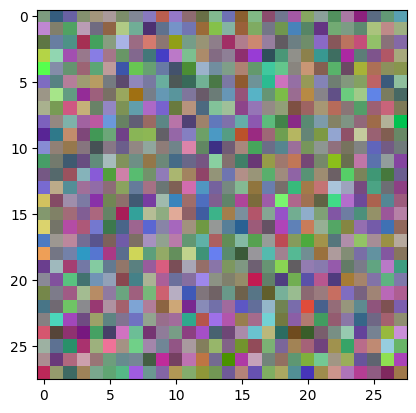

(-0.015103157690262312, 0.8638278930943566)


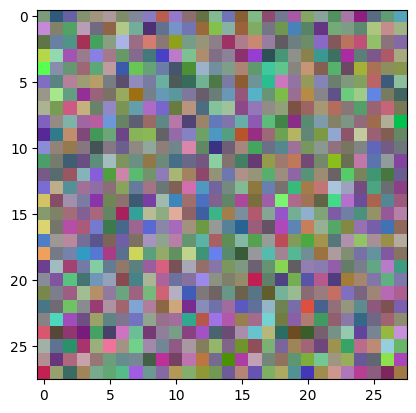

(-0.025859417992221263, 0.7457196834011344)


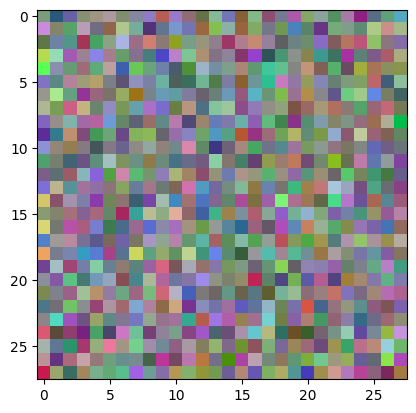

(-0.039029057077361096, 0.6399691907798671)


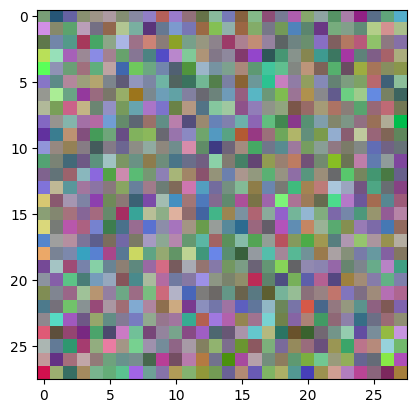

(-0.05339202797915332, 0.5582208076870916)


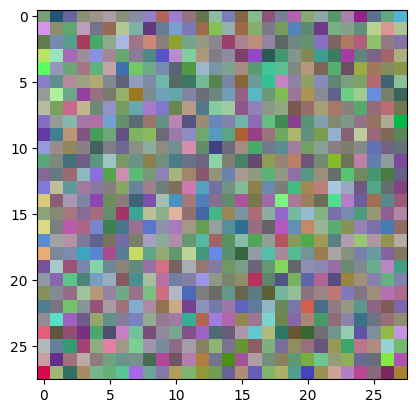

(-0.06218236966441914, 0.48628716091997537)


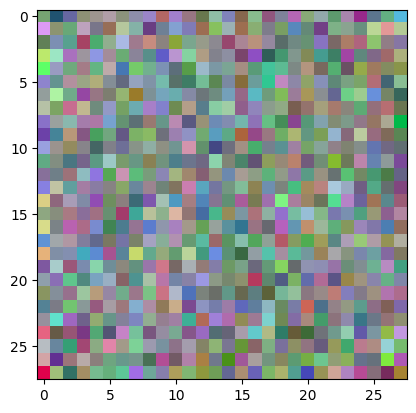

(-0.06603397930860809, 0.4279877547114894)


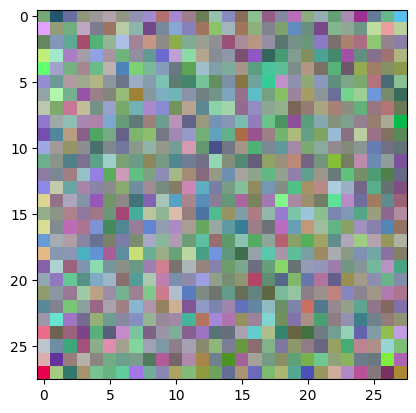

(-0.07101341668359369, 0.3791401474114616)


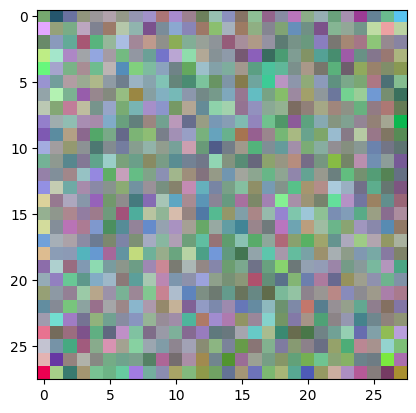

(-0.07956764099395755, 0.3404761033268084)


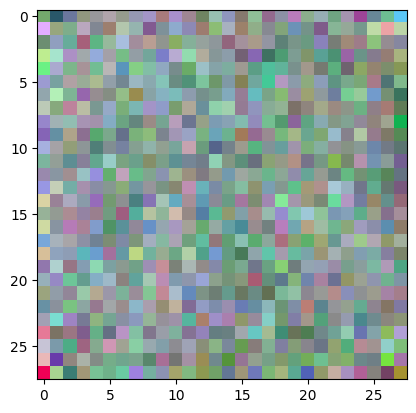

(-0.08920078271252169, 0.3073578343223688)


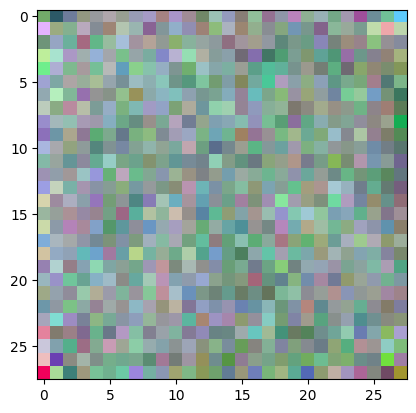

(-0.09449455826090601, 0.2835755354037639)


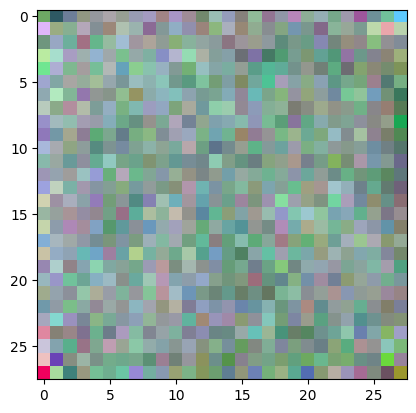

(-0.09791089780120157, 0.2670914244785406)


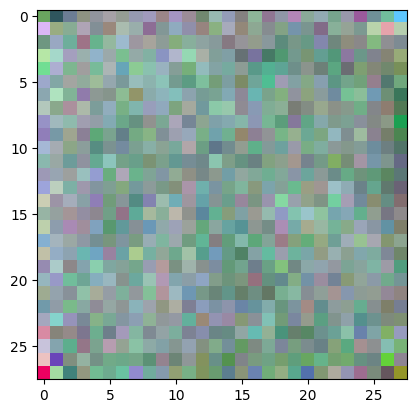

(-0.10349087752309649, 0.2550022420829547)


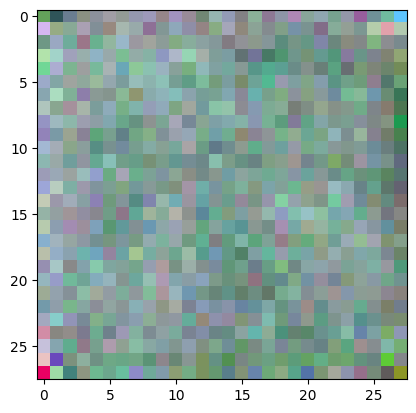

(-0.10867196942841169, 0.24602632297726756)


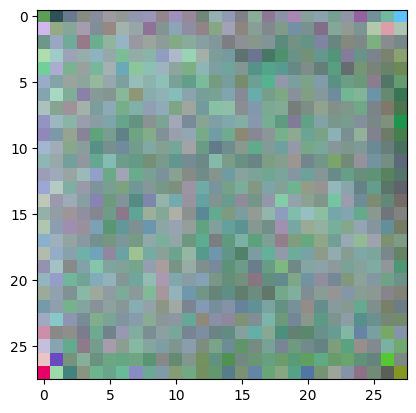

(-0.11063005318504401, 0.2430513221529102)


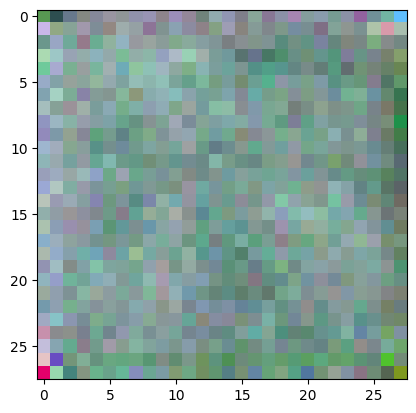

(-0.1153110915417089, 0.24479460662938565)


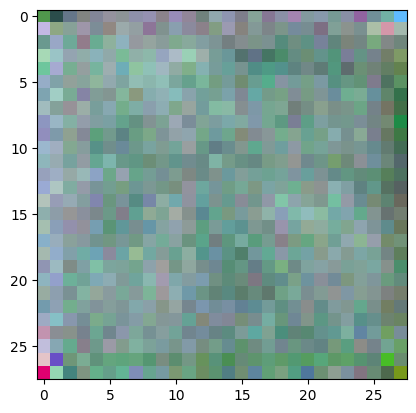

(-0.12100648989788364, 0.24708408872363524)


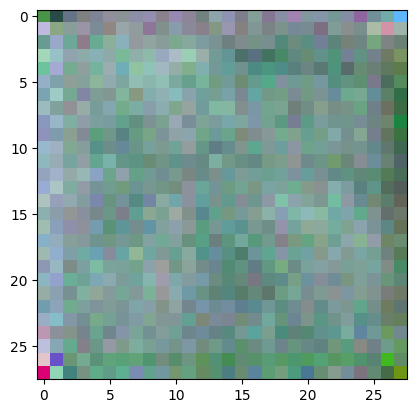

(-0.12191145382255808, 0.24765730117813803)


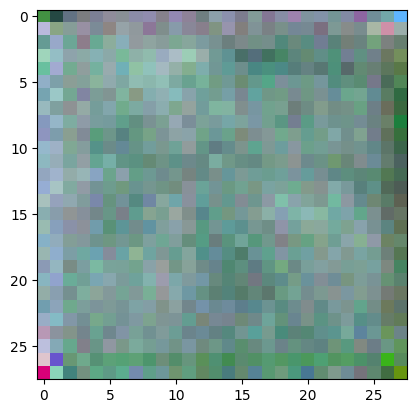

(-0.12222490992766963, 0.2474259489385479)


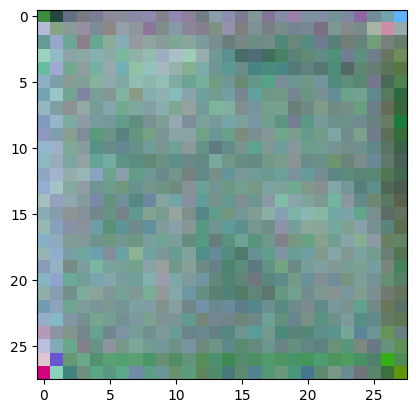

(0.36318995464698783, 0.1284466864217916)


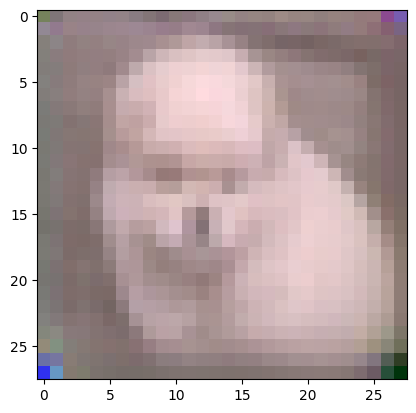

1it [00:10, 10.22s/it]


In [18]:
#@title Sampling image
samples = []

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  diffuse_sample(data[None], samples, diffusion_coeff_fn, marginal_prob_std_fn)
  samples = np.concatenate(samples, axis = 1)
  for i in range(samples.shape[0]):
    print(f'{samples[i].mean(), samples[i].std()}')
    plt.imshow(((samples[i] - samples[i].min())/(samples[i].max() - samples[i].min())).transpose(1, 2, 0))
    plt.show()